## COMP 551 - A2
## Camilo Garcia La Rotta #260657037
### 1. Generalized Discriminant Analysis 
Firstly we import the given datasets:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

c1_means   = np.genfromtxt('./Datasets/DS1_m_1.txt', delimiter=',')
c2_means   = np.genfromtxt('./Datasets/DS1_m_0.txt', delimiter=',')
c1_c2_cov = np.genfromtxt('./Datasets/Ds1_Cov.txt', delimiter=',')

# get rid of extra column parsed by read_csv due to \n
c1_means = c1_means[:-1]
c2_means = c2_means[:-1]
c1_c2_cov = c1_c2_cov[:, :-1]

print('C1 means: {}\nC2 means: {}\nC1-C2 Cov: {}'.format(c1_means.shape,c2_means.shape,c1_c2_cov.shape))

C1 means: (20,)
C2 means: (20,)
C1-C2 Cov: (20, 20)


Generate 2 classes, each with 20 features and 2000 samples:

In [2]:
shape = (2000)
df1 = pd.DataFrame(np.random.multivariate_normal(c1_means,c1_c2_cov,shape))
df2 = pd.DataFrame(np.random.multivariate_normal(c2_means,c1_c2_cov,shape))

# append the labels to each data set
df1['y'] = 1
df2['y'] = 0

print('Data set for Class 1 has shape: {}'.format(df1.shape))
print('Data set for Class 2 has shape: {}'.format(df2.shape))

Data set for Class 1 has shape: (2000, 21)
Data set for Class 2 has shape: (2000, 21)


Next, we will take a homogenious ratio of both classes to form training and testing data sets with 70/30 ratio:

In [3]:
def add_bias(df):
    if not 'bias' in df.columns:
        df.insert(0,'bias',1)
    return df

def train_test_split(df):
    # split data set 70/30
    train = df.sample(frac=0.7).reset_index(drop=True)
    test = df.drop(train.index).reset_index(drop=True)
    
    # divide each data set into features and labels
    X_train = train.iloc[:,:-1]
    y_train = train.iloc[:,-1]
    
    X_test = test.iloc[:,:-1]  
    y_test = test.iloc[:,-1]
    
    return (X_train, X_test, y_train, y_test)
    
# merge and shuffle the two input dataframes
def merge(df1, df2):
    # combine both data sets
    df = df1.append(df2, ignore_index=True)
    # shuffle samples
    return df.sample(frac=1, random_state=42).reset_index(drop=True)


X_train1, X_test1, y_train1, y_test1 = train_test_split(df1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2)

X_train = merge(X_train1, X_train2)
y_train = merge(y_train1, y_train2)

X_test  = merge(X_test1, X_test2)
y_test  = merge(y_test1, y_test2)

print('X_train: {}\ty_train: {}\nX_test: {}\ty_test: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (2800, 20)	y_train: (2800,)
X_test: (1200, 20)	y_test: (1200,)


We will save the testing set as DS1:

In [4]:
DS1_train = X_train.copy(deep=True)
DS1_test  = X_test.copy(deep=True)

DS1_train['y'] = y_train
DS1_test['y']  = y_test

DS1_train.to_csv('./Output/DS1_train.csv')
DS1_test.to_csv('./Output/DS1_test.csv')

### 2. Maximum Likelihood Approach
The likelihood of a datapoint $x^{(n)}$, $t^{(n)}$ is given by:

$$[\pi \mathcal{N}(x^{(n)}\mid\mu_{1},\Sigma)]^{t^{(n)}}[(1 - \pi)  \mathcal{N}(x^{(n)}\mid\mu_{2},\Sigma)]^{1-t^{(n)}}$$


Lets first obtain the relevant values from the training dataset:


In [5]:
N = y_train.shape[0]
N1, N2 = y_train.value_counts()

# features of classes 1,2 
X_c1 = X_train.loc[y_train.index[y_train == 1]]
X_c2 = X_train.loc[y_train.index[y_train == 0]]

Maximization wrt to $\mu_{1}$, $\mu_{2}$: 

In [6]:
m1 = X_c1.mean(axis=0)
m2 = X_c2.mean(axis=0)

Maximization wrt to $\Sigma$:

In [7]:
S1 = (X_c1 - m1).T.dot((X_c1 - m1)) / N1
S2 = (X_c2 - m2).T.dot((X_c2 - m2)) / N2

cov = (N1 * S1 / N) + (N2 * S2 / N)

Now we can train the model:

In [8]:
import math

sigmoid = lambda x: 1 / (1 + np.exp(-x))

cov_inv = np.linalg.pinv(cov)

W   = cov_inv.dot(m1 - m2)
w_0 = (-1/2) * m1.T.dot(cov_inv).dot(m1) + \
        (1/2) * m2.T.dot(cov_inv).dot(m2) + math.log(N1 / N2)
    
W = np.concatenate((np.array([w_0]),W), axis=0)

clf = lambda W, X: 1 if sigmoid(X.dot(W.T)) > 0.5 else 0

Finally, we test the accuracy of the classifier:

In [9]:
add_bias(X_test)
y_pred = X_test.apply(lambda x: clf(W,x), axis=1)
X_test = X_test.drop('bias',1)

def get_confusion_matrix(y_pred, y_test):
    # we will apply a simple trick to derive the confusion matrix of the model
    #     pred     actual
    #  2*  1    -    1     =  1  TP
    #  2*  1    -    0     =  2  FP
    #  2*  0    -    1     = -1  FN
    #  2*  0    -    0     =  0  TN
    counts = [2 * pred - test for pred, test in zip(y_pred,y_test)]
    
    return {'TP':counts.count(1), 'FP':counts.count(2), 'FN':counts.count(-1), 'TN':counts.count(0) }

get_accuracy  = lambda conf, N: (conf['TP'] + conf['TN']) / N
def get_precision(conf):
    total_pred_positive = conf['TP'] + conf['FP']
    if total_pred_positive == 0: return 0
    return conf['TP'] / total_pred_positive

def get_recall(conf):
    total_positive = conf['TP'] + conf['FN']
    if total_positive == 0: return 0
    return conf['TP'] / total_positive
    
def get_f1(p,r):
    p_plus_r = p + r
    if p_plus_r == 0: return 0
    return 2 * p * r / p_plus_r

def print_metrics(conf, N):
    accuracy  = get_accuracy(conf, N)
    p  = get_precision(conf)
    r  = get_recall(conf)
    f1 = get_f1(p, r)
    
    print('Confusion Matrix: {}'.format(conf))
    print('Accuracy:\t{:.4f}'.format(accuracy))
    print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF_1:\t\t{:.4f}'.format(p, r, f1))

print_metrics(get_confusion_matrix(y_pred, y_test), len(y_test))

Confusion Matrix: {'TP': 569, 'FP': 24, 'FN': 31, 'TN': 576}
Accuracy:	0.9542
Precision:	0.9595
Recall:		0.9483
F_1:		0.9539


The learnt coefficients are:

In [10]:
np.set_printoptions(precision=4)
print('w_0: {:.4f}'.format(w_0))
print('W: \n{}'.format(W[1:]))

w_0: -28.0121
W: 
[-14.6612   8.824    6.462    3.5058   9.9667   4.1559 -18.1957  24.4723
  30.0877  -9.0526  13.4491  13.403  -16.5662 -13.4195   5.7705 -13.2981
 -30.8527   6.6925   1.0537   5.1807]


### 3. kNN
Note that because the distance between each point depends on the unit of measurement, normalization of the features is strongly recommended for kNN.

In [11]:
print('X_train: {}\ty_train: {}\nX_test: {}\ty_test: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (2800, 20)	y_train: (2800,)
X_test: (1200, 20)	y_test: (1200,)


Now we will score the classification of the testing sample with kNN:

In [12]:
def calculate_distances(X_train, X_test):
    train_squared = np.sum(X_train**2, axis=1)[:, np.newaxis]
    test_squared  = np.sum(X_test**2, axis=1)[:, np.newaxis]
    train_test    = np.dot(X_test, X_train.T)   
    
    return (-2 * train_test.T + train_squared).T + test_squared

def get_k_closest_labels(dist, y, k):
    neighbour_idx = np.argpartition(dist, -k)[-k:]
    
    return y.iloc[neighbour_idx]

def majority_vote(neighbour_labels):
    c1 = neighbour_labels.count(1)
    c2 = neighbour_labels.count(0)
    
    return 1 if c1 > c2 else 0


def kNN(dists, y, K):
    confusions, F1s = [], []
    y_pred = {}
    for k in K:
        y_pred = []
        for row in dists:
            
            k_labels = get_k_closest_labels(row, y, k)
            pred     = majority_vote(k_labels.tolist())
            y_pred.append(pred)

        conf = get_confusion_matrix(y_pred, y.tolist())
        p    = get_precision(conf)
        r    = get_recall(conf)
        f1   = get_f1(p, r)
        confusions.append((k,conf))
        F1s.append(f1)
        
    return confusions, F1s

dists    = calculate_distances(X_train, X_test)
confusions, F1s = kNN(dists, y_train, np.arange(1,501,10)) 

Lets visualize the accuracy of the classifier wrt k:

Max F1: 0.4966 with k=21


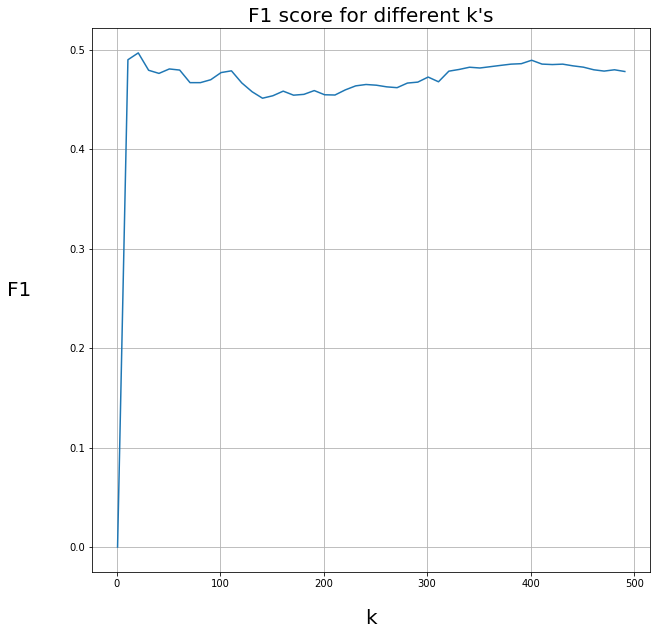

In [13]:
xs = [c[0] for c in confusions]

max_idx = F1s.index(max(F1s))
print('Max F1: {:.4f} with k={}'.format(F1s[max_idx], xs[max_idx]))

fig, ax = plt.subplots(figsize=(10,10))

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('grid', linestyle="--", color='black')

ax.plot(xs,F1s)

plt.title('F1 score for different k\'s', fontsize=20)
plt.xlabel('k', fontsize=20, labelpad=20)
plt.ylabel('F1', fontsize=20, labelpad=50, rotation=0)

plt.grid()
plt.show()

The metrics for the optimal value of k are the following:

In [14]:
confusions, F1s = kNN(dists, y_train, [xs[max_idx]])

for k, conf in confusions:
    print('k = {}'.format(k))
    print_metrics(conf, len(y_test)) 

k = 21
Confusion Matrix: {'TP': 293, 'FP': 283, 'FN': 311, 'TN': 313}
Accuracy:	0.5050
Precision:	0.5087
Recall:		0.4851
F_1:		0.4966


### 4. Multivariate Gaussian
First import the datasets and generate the Gaussian distributions:

In [15]:
c1_m1 = np.genfromtxt('./Datasets/DS2_c1_m1.txt', delimiter=',')
c1_m2 = np.genfromtxt('./Datasets/DS2_c1_m2.txt', delimiter=',')
c1_m3 = np.genfromtxt('./Datasets/DS2_c1_m3.txt', delimiter=',')

c2_m1 = np.genfromtxt('./Datasets/DS2_c2_m1.txt', delimiter=',')
c2_m2 = np.genfromtxt('./Datasets/DS2_c2_m2.txt', delimiter=',')
c2_m3 = np.genfromtxt('./Datasets/DS2_c2_m3.txt', delimiter=',')

cov1 = np.genfromtxt('./Datasets/DS2_Cov1.txt', delimiter=',')
cov2 = np.genfromtxt('./Datasets/DS2_Cov2.txt', delimiter=',')
cov3 = np.genfromtxt('./Datasets/DS2_Cov3.txt', delimiter=',')

# get rid of extra column parsed by read_csv due to \n
c1_m1 = c1_m1[:-1]
c1_m2 = c1_m2[:-1]
c1_m3 = c1_m3[:-1]

c2_m1 = c2_m1[:-1]
c2_m2 = c2_m2[:-1]
c2_m3 = c2_m3[:-1]

cov1 = cov1[:, :-1]
cov2 = cov2[:, :-1]
cov3 = cov3[:, :-1]

shape = (2000)
c1_G1 = pd.DataFrame(np.random.multivariate_normal(c1_m1,cov1,shape))
c1_G2 = pd.DataFrame(np.random.multivariate_normal(c1_m2,cov2,shape))
c1_G3 = pd.DataFrame(np.random.multivariate_normal(c1_m3,cov3,shape))

c2_G1 = pd.DataFrame(np.random.multivariate_normal(c2_m1,cov1,shape))
c2_G2 = pd.DataFrame(np.random.multivariate_normal(c2_m2,cov2,shape))
c2_G3 = pd.DataFrame(np.random.multivariate_normal(c2_m3,cov3,shape))

Next generate both classes with the given probabilities:

In [16]:
df1 = c1_G1.sample(frac=0.1, random_state=42).reset_index(drop=True)
df1 = df1.append(c1_G2.sample(frac=0.42, random_state=42).reset_index(drop=True), ignore_index=True)
df1 = df1.append(c1_G3.sample(frac=0.48, random_state=42).reset_index(drop=True), ignore_index=True)

df2 = c2_G1.sample(frac=0.1, random_state=42).reset_index(drop=True)
df2 = df2.append(c2_G2.sample(frac=0.42, random_state=42).reset_index(drop=True), ignore_index=True)
df2 = df2.append(c2_G3.sample(frac=0.48, random_state=42).reset_index(drop=True), ignore_index=True)

# append the labels to each data set
df1['y'] = 1
df2['y'] = 0

print('Data set for Class 1 has shape: {}'.format(df1.shape))
print('Data set for Class 2 has shape: {}'.format(df2.shape))

Data set for Class 1 has shape: (2000, 21)
Data set for Class 2 has shape: (2000, 21)


Next, we will take a homogenious ratio of both classes to form training and testing data sets with 70/30 ratio:

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2)

X_train = merge(X_train1, X_train2)
y_train = merge(y_train1, y_train2)

X_test  = merge(X_test1, X_test2)
y_test  = merge(y_test1, y_test2)

print('X_train: {}\ty_train: {}\nX_test: {}\ty_test: {}'.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train: (2800, 20)	y_train: (2800,)
X_test: (1200, 20)	y_test: (1200,)


We will save the testing set as DS2:

In [18]:
DS2_train = X_train.copy(deep=True)
DS2_test  = X_test.copy(deep=True)

DS2_train['y'] = y_train
DS2_test['y']  = y_test

DS2_train.to_csv('./Output/DS2_train.csv')
DS2_test.to_csv('./Output/DS2_test.csv')

### Maximum Likelihood Approach
Learn the parameters and fit the model:

In [19]:
N = y_train.shape[0]
N1, N2 = y_train.value_counts()

# features of classes 1,2 
X_c1 = X_train.loc[y_train.index[y_train == 1]]
X_c2 = X_train.loc[y_train.index[y_train == 0]]

m1 = X_c1.mean(axis=0)
m2 = X_c2.mean(axis=0)

S1 = (X_c1 - m1).T.dot((X_c1 - m1)) / N1
S2 = (X_c2 - m2).T.dot((X_c2 - m2)) / N2

cov = (N1 * S1 / N) + (N2 * S2 / N)

cov_inv = np.linalg.pinv(cov)

W   = cov_inv.dot(m1 - m2)
w_0 = (-1/2) * m1.T.dot(cov_inv).dot(m1) + \
        (1/2) * m2.T.dot(cov_inv).dot(m2) + math.log(N1 / N2)
    
W = np.concatenate((np.array([w_0]),W), axis=0)

Test the accuracy:

In [20]:
add_bias(X_test)
y_pred = X_test.apply(lambda x: clf(W,x), axis=1)
X_test = X_test.drop('bias',1)

print_metrics(get_confusion_matrix(y_pred, y_test), len(y_test))

Confusion Matrix: {'TP': 290, 'FP': 366, 'FN': 310, 'TN': 234}
Accuracy:	0.4367
Precision:	0.4421
Recall:		0.4833
F_1:		0.4618


The learnt coefficients are:

In [21]:
np.set_printoptions(precision=4)
print('w_0: {:.4f}'.format(w_0))
print('W: \n{}'.format(W[1:]))

w_0: 0.0558
W: 
[-0.0367 -0.0078  0.0044 -0.0201 -0.0801 -0.035  -0.0107  0.0225  0.012
  0.0048 -0.0237 -0.0196 -0.0106  0.0151  0.0816  0.0538  0.0106 -0.0117
  0.0222 -0.0187]


### kNN
Fit the classifier:

In [22]:
dists    = calculate_distances(X_train, X_test)
confusions, F1s = kNN(dists, y_train, np.arange(1,501,10)) 

Plot the F1 score over different k's:

Max F1: 0.6180 with k=391


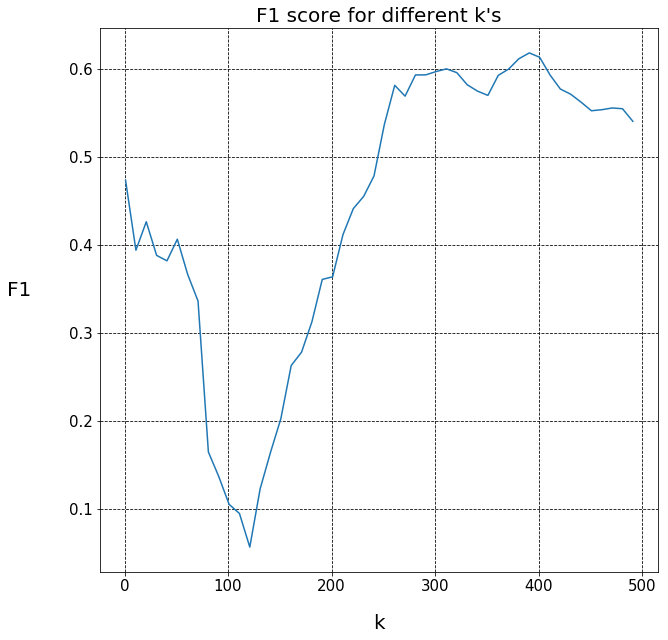

In [23]:
xs = [c[0] for c in confusions]

max_idx = F1s.index(max(F1s))
print('Max F1: {:.4f} with k={}'.format(F1s[max_idx], xs[max_idx]))

fig, ax = plt.subplots(figsize=(10,10))

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('grid', linestyle="--", color='black')

ax.plot(xs,F1s)

plt.title('F1 score for different k\'s', fontsize=20)
plt.xlabel('k', fontsize=20, labelpad=20)
plt.ylabel('F1', fontsize=20, labelpad=50, rotation=0)

plt.grid()
plt.show()

The metrics for the optimal value of k are the following:

In [24]:
confusions, F1s = kNN(dists, y_train, [xs[max_idx]])

for k, conf in confusions:
    print('k = {}'.format(k))
    print_metrics(conf, len(y_test)) 

k = 391
Confusion Matrix: {'TP': 491, 'FP': 494, 'FN': 113, 'TN': 102}
Accuracy:	0.4942
Precision:	0.4985
Recall:		0.8129
F_1:		0.6180
